<a href="https://www.kaggle.com/code/omarelhakim0/frauddetection-ai-model-ipynb?scriptVersionId=178005253" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
# Hakim
import numpy as np
import pandas as pd
from  sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score,recall_score, roc_auc_score,confusion_matrix,balanced_accuracy_score,accuracy_score,precision_recall_curve,roc_curve
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle

# Data Preprocessing 

In [2]:
# Hakim
train_df=pd.read_csv('/kaggle/input/frauddetection-data/fraudTrain.csv') # no need for all the data
test_df=pd.read_excel('/kaggle/input/frauddetection-data/fraudTest.xlsx')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002104 entries, 0 to 1002103
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ID           1002104 non-null  int64  
 1   Time         1002104 non-null  object 
 2   Card Number  1002104 non-null  float64
 3   merchant     1002104 non-null  object 
 4   category     1002104 non-null  object 
 5   Amount       1002103 non-null  float64
 6   firstName    1002103 non-null  object 
 7   lastName     1002103 non-null  object 
 8   trans_num    1002103 non-null  object 
 9   is_fraud     1002103 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 76.5+ MB


In [7]:
average_amount_all = train_df['Amount'].mean()
train_df['Amount_diff_avg'] = train_df['Amount'] - average_amount_all

train_df['Time'] = pd.to_datetime(train_df['Time'])
train_df['Hour'] = train_df['Time'].dt.hour
train_df['DayOfWeek'] = train_df['Time'].dt.dayofweek
train_df['IsWeekend'] = train_df['DayOfWeek'] >= 5

train_df['LogAmount'] = np.log1p(train_df['Amount'])

train_df['TransactionCountPerCard'] = train_df.groupby('Card Number')['Card Number'].transform('count')

train_df['TimeSinceLastTransaction'] = train_df.groupby('Card Number')['Time'].diff().dt.total_seconds()
train_df['TimeSinceLastTransaction']=train_df['TimeSinceLastTransaction'].fillna(0)

merchant_freq = train_df['merchant'].value_counts() / len(train_df)
category_freq = train_df['category'].value_counts() / len(train_df)
train_df['MerchantFreq'] = train_df['merchant'].map(merchant_freq)
train_df['CategoryFreq'] = train_df['category'].map(category_freq)

train_df['merchant'] = train_df['merchant'].astype('category').cat.codes
train_df['category'] = train_df['category'].astype('category').cat.codes

train_df.dropna(inplace=True)
train_df.drop(columns=['ID','firstName','lastName','trans_num'],inplace=True)
train_df.head()

,Time,Card Number,merchant,category,Amount,is_fraud,Amount_diff_avg,Hour,DayOfWeek,IsWeekend,LogAmount,TransactionCountPerCard,TimeSinceLastTransaction,MerchantFreq,CategoryFreq
0,2019-01-01 00:00:00,2.700000e+15,514,9,4.97,0.0,-65.286157,0,1,False,1.786747,1578,0.0,0.001002,0.048654
1,2019-01-01 00:00:00,6.300000e+11,241,4,107.23,0.0,36.973843,0,1,False,4.684259,13879,0.0,0.001920,0.095141
2,2019-01-01 00:00:00,3.890000e+13,390,0,220.11,0.0,149.853843,0,1,False,5.398660,1546,0.0,0.001447,0.072554
3,2019-01-01 00:01:00,3.530000e+15,360,2,45.00,0.0,-25.256157,0,1,False,3.828641,21329,0.0,0.001986,0.101514
4,2019-01-01 00:03:00,3.760000e+14,297,10,41.96,0.0,-28.296157,0,1,False,3.760269,11846,0.0,0.001199,0.061529


# We created alot of columns , let's see which ones are important

In [8]:
np.abs(train_df[train_df.columns].corr()['is_fraud'][:]).sort_values(ascending=False)

is_fraud                    1.000000
Amount                      0.217171
Amount_diff_avg             0.217171
LogAmount                   0.119004
category                    0.019780
Hour                        0.012535
Time                        0.011241
TimeSinceLastTransaction    0.010764
MerchantFreq                0.007783
CategoryFreq                0.005361
Card Number                 0.003599
IsWeekend                   0.003119
TransactionCountPerCard     0.001809
DayOfWeek                   0.000755
merchant                    0.000502
Name: is_fraud, dtype: float64

In [9]:
train_df.drop(columns=['merchant','DayOfWeek','TransactionCountPerCard','IsWeekend','Card Number','CategoryFreq','MerchantFreq','LogAmount','TimeSinceLastTransaction','Time'],inplace=True)

In [10]:
train_df.head()

,category,Amount,is_fraud,Amount_diff_avg,Hour
0,9,4.97,0.0,-65.286157,0
1,4,107.23,0.0,36.973843,0
2,0,220.11,0.0,149.853843,0
3,2,45.00,0.0,-25.256157,0
4,10,41.96,0.0,-28.296157,0


# Applying the same tranformations on the test data

In [11]:
average_amount_all = test_df['Amount'].mean()
test_df['Amount_diff_avg'] = test_df['Amount'] - average_amount_all

test_df['Time'] = pd.to_datetime(test_df['Time'])
test_df['Hour'] = test_df['Time'].dt.hour

test_df['category'] = test_df['category'].astype('category').cat.codes
test_df.dropna(inplace=True)
test_df.drop(columns=['ID','firstName','lastName','trans_num','merchant','Time','Card Number'],inplace=True)
test_df.head()

,category,Amount,is_fraud,Amount_diff_avg,Hour
0,10,2.86,0,-66.53281,12
1,10,29.84,0,-39.55281,12
2,5,41.28,0,-28.11281,12
3,9,60.05,0,-9.34281,12
4,13,3.19,0,-66.20281,12


In [12]:
y_train=np.array(train_df['is_fraud'])
y_test=np.array(test_df['is_fraud'])

In [13]:
x_train=np.array(train_df.drop('is_fraud',axis=1))
x_test=np.array(test_df.drop('is_fraud',axis=1))

* To get the percentage of positives in the data 

In [14]:
# Hakim
y_train.sum()/len(y_train)*100

0.570101077434156

#  The data is highly imbalanced ,only 0.5% of the data is positive , which makes the model overfit

* To make the data balanced , we will take all of the positive class in the data (990) and only 2750 of the negative class

In [15]:
Counter(y_train)

Counter({0.0: 996390, 1.0: 5713})

In [16]:
# Apply SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [17]:
Counter(y_train)

Counter({0.0: 996390, 1.0: 996390})

# SMOTE just adds 1 class at the end , so we need to shuffle the data

In [18]:
y_train[1200000:]

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
np.random.seed(42)
np.random.shuffle(x_train)
np.random.seed(42)  # for some reason the seed has to be set twice
np.random.shuffle(y_train)

In [43]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

# Model Evaluation

In [44]:
y_pred_rf = rf.predict(x_test) # getting predictions on test data for evaluation

# Random Forest results

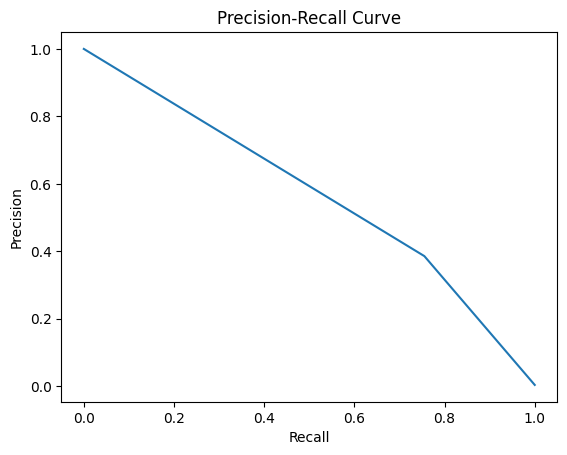

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_rf)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
p_score= precision_score(y_test, y_pred_rf)
r_score=recall_score(y_test,y_pred_rf)

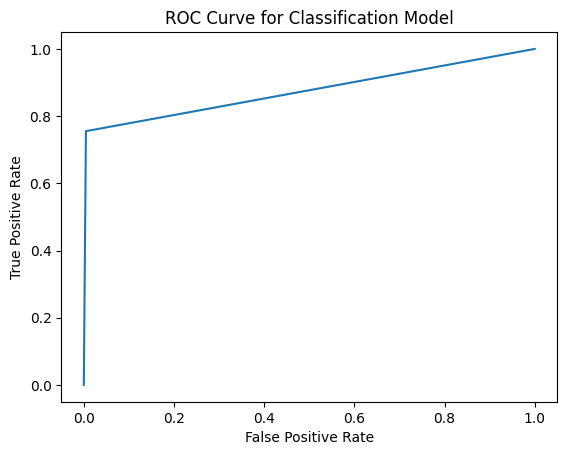

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Model')
plt.show()
auc_prc = roc_auc_score(y_test, y_pred_rf)

In [47]:
balanced_accuracy=balanced_accuracy_score(y_test,y_pred_rf)
accuracy=accuracy_score(y_test,y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("accuracy          : " ,accuracy)
print("balanced accuracy : " ,balanced_accuracy)
print("F1 score          : ", f1)
print("precision score   : ", p_score)
print("recall score      : ", r_score)
print("AUC-PRC scoree    : ", auc_prc)

accuracy          :  0.994412643800194
balanced accuracy :  0.8752920658664064
F1 score          :  0.5106382978723405
precision score   :  0.38571428571428573
recall score      :  0.7552447552447552
AUC-PRC scoree    :  0.8752920658664064


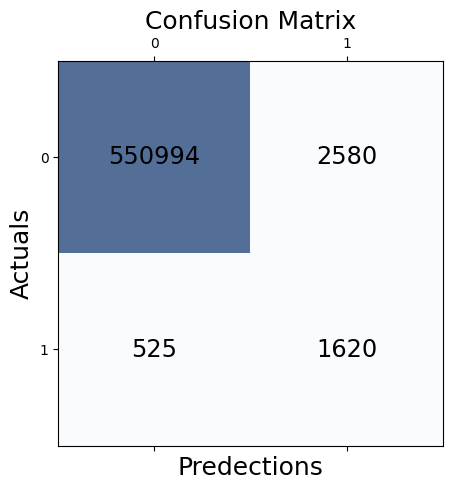

In [48]:
cm = confusion_matrix(y_test, y_pred_rf)

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha = 0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j,y=i,s=cm[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predections',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

# The test data is highly imbalanced , so lets get oredictions on a smaller set

In [40]:
Counter(y_test)

Counter({0: 553574, 1: 2145})

In [49]:
balanced_x_test = np.concatenate(
    (x_test[np.where(y_test == 1)], x_test[np.where(y_test[:8000] == 0)])
)
balanced_y_test = np.concatenate(
    (y_test[np.where(y_test == 1)], y_test[np.where(y_test[:8000] == 0)])
)

In [50]:
balanced_y_pred_rf = rf.predict(balanced_x_test) # getting predictions on a balanced test data for evaluation

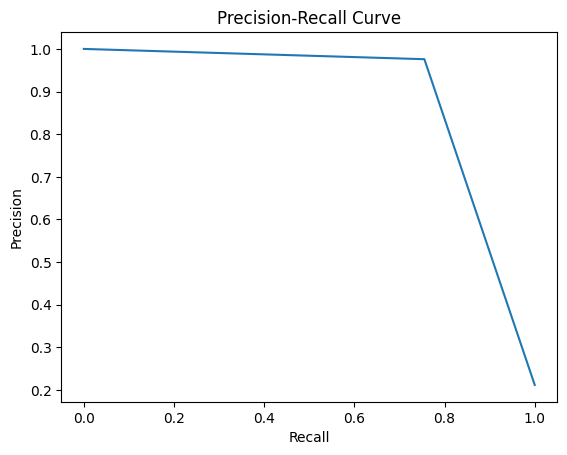

In [52]:
precisions, recalls, thresholds = precision_recall_curve(balanced_y_test, balanced_y_pred_rf)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
p_score= precision_score(balanced_y_test, balanced_y_pred_rf)
r_score=recall_score(balanced_y_test,balanced_y_pred_rf)

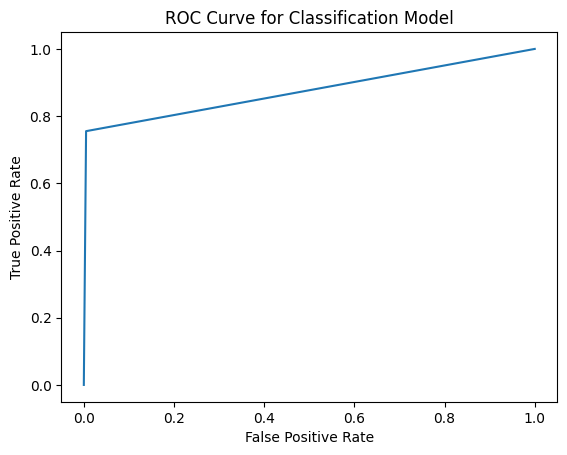

In [53]:
fpr, tpr, thresholds = roc_curve(balanced_y_test, balanced_y_pred_rf)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Model')
plt.show()
auc_prc = roc_auc_score(balanced_y_test, balanced_y_pred_rf)

In [54]:
balanced_accuracy=balanced_accuracy_score(balanced_y_test,balanced_y_pred_rf)
accuracy=accuracy_score(balanced_y_test,balanced_y_pred_rf)
f1 = f1_score(balanced_y_test, balanced_y_pred_rf)

print("accuracy          : " ,accuracy)
print("balanced accuracy : " ,balanced_accuracy)
print("F1 score          : ", f1)
print("precision score   : ", p_score)
print("recall score      : ", r_score)
print("AUC-PRC scoree    : ", auc_prc)

accuracy          :  0.9441865059764892
balanced accuracy :  0.875115483663992
F1 score          :  0.8515111695137977
precision score   :  0.9759036144578314
recall score      :  0.7552447552447552
AUC-PRC scoree    :  0.875115483663992


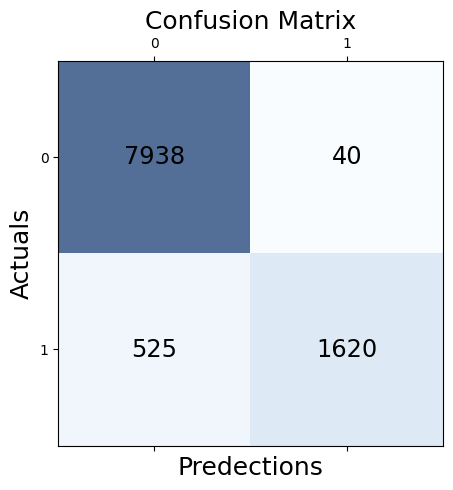

In [55]:
cm = confusion_matrix(balanced_y_test, balanced_y_pred_rf)

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha = 0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j,y=i,s=cm[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predections',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

In [ ]:
svm = SVC(kernel="rbf", gamma=0.4, C=1.0)
svm.fit(x_train, y_train)

# SVM Model results

In [ ]:
y_pred_svm = svm.predict(x_test) # getting predictions on test data for evaluation

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_svm)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
p_score= precision_score(y_test, y_pred_svm)
r_score=recall_score(y_test,y_pred_svm)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Model')
plt.show()
auc_prc = roc_auc_score(y_test, y_pred_svm)

In [ ]:
balanced_accuracy=balanced_accuracy_score(y_test,y_pred_svm)
accuracy=accuracy_score(y_test,y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print("accuracy          : " ,accuracy)
print("balanced accuracy : " ,balanced_accuracy)
print("F1 score          : ", f1)
print("precision score   : ", p_score)
print("recall score      : ", r_score)
print("AUC-PRC scoree    : ", auc_prc)

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha = 0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j,y=i,s=cm[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predections',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

# Deployment and Monitoring:

In [ ]:
filename = "svm_model.pth"

with open(filename, 'wb') as f:
    pickle.dump(svm, f)
    
print(f"Model saved to {filename}")
with open(filename, 'rb') as f:
    loaded_svm_model = pickle.load(f)
    
print(f"Model loaded from {filename}")

In [56]:
filename = "rf_model.pth"

with open(filename, 'wb') as f:
    pickle.dump(rf, f)
    
print(f"Model saved to {filename}")
with open(filename, 'rb') as f:
    loaded_rf_model = pickle.load(f)
    
print(f"Model loaded from {filename}")

Model saved to rf_model.pth
Model loaded from rf_model.pth
